# Plot Viual Odometry

In [1]:
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
from copy import copy

def transform(t_x, t_y, t_z, r_x, r_y, r_z, r_w):
    return np.asarray(
        [[1-2*r_y**2-2*r_z**2, 2*r_x*r_y-2*r_z*r_w, 2*r_x*r_z+2*r_y*r_w, t_x],
         [2*r_x*r_y+2*r_z*r_w, 1-2*r_x**2-2*r_z**2, 2*r_y*r_z-2*r_x*r_w, t_y],
         [2*r_x*r_z-2*r_y*r_w, 2*r_y*r_z+2*r_x*r_w, 1-2*r_x**2-2*r_y**2, t_z],
         [0,0,0,1]])
# https://en.wikipedia.org/wiki/Rotation_matrix#General_rotations

In [2]:
df = pd.read_csv("/home/torsten/ms/data/rosbag2_2023_07_06-06_07_41/vo.csv")
df

,timestamp,t_x,t_y,t_z,r_x,r_y,r_z,r_w
0,1688638061467,7.145981e-04,3.434214e-04,-4.160556e-03,-0.000056,-0.000067,-0.000034,1.0
1,1688638061524,8.849132e-06,2.967866e-06,-2.349775e-05,0.000000,0.000000,0.000000,1.0
2,1688638061630,5.609402e-14,1.743050e-14,-9.681145e-14,0.000000,0.000000,0.000000,1.0
3,1688638061671,-6.937506e-14,-1.665335e-15,1.145750e-13,0.000000,0.000000,0.000000,1.0
4,1688638061727,1.021095e-04,-3.431170e-05,-9.998794e-04,-0.000008,-0.000002,-0.000015,1.0
...,...,...,...,...,...,...,...,...
864,1688638119054,3.811957e-08,-2.957398e-08,-2.956941e-07,0.000000,0.000000,0.000000,1.0
865,1688638119126,8.432219e-09,-1.181513e-09,-1.619919e-08,0.000000,0.000000,0.000000,1.0
866,1688638119194,-1.811597e-04,-7.162061e-05,2.219662e-04,-0.000004,0.000008,-0.000010,1.0
867,1688638119251,2.535192e-05,-3.446608e-06,-1.102626e-04,0.000000,0.000000,0.000000,1.0


In [3]:
df_kf = pd.read_csv("/home/torsten/ms/data/rosbag2_2023_07_06-06_07_41/kf.csv")
#df_kf = df_kf.iloc[1:]
df_kf

,timestamp,t_x,t_y,t_z,r_x,r_y,r_z,r_w
0,1688638066403,0.258870,0.108626,-0.409178,0.001035,0.137583,0.006255,0.990471
1,1688638067019,0.185535,-0.025772,0.319534,-0.001507,0.133432,0.006924,0.991033
2,1688638067533,0.121643,0.000237,0.215993,0.001359,0.128170,0.002003,0.991749
3,1688638068188,0.197898,-0.015894,0.467110,-0.001402,0.131761,-0.003953,0.991273
4,1688638068858,0.174887,-0.004743,0.517626,-0.003294,0.126460,-0.006745,0.991943
5,1688638071123,0.272996,-0.070010,1.982925,-0.011390,0.003616,-0.010126,0.999878
6,1688638073860,-0.175996,-0.021920,1.895641,-0.008349,-0.136615,0.000318,0.990589
7,1688638074471,-0.148152,0.004058,0.260746,-0.002437,-0.136739,0.005436,0.990589
8,1688638075058,-0.120354,-0.021431,0.209011,-0.003797,-0.133200,0.004394,0.991072
9,1688638075670,-0.160001,0.007403,0.315646,0.003470,-0.133860,-0.001343,0.990993


In [4]:
poses = []
poses_kf = []
last_tf = transform(0,0,0,0,0,0,1)

vo_T_robot = np.asarray([[ 0,  0, 1, 0],
                         [-1,  0, 0, 0],
                         [ 0, -1, 0, 0],
                         [ 0,  0, 0, 1]], dtype=float)

vTr_inv = np.linalg.inv(vo_T_robot)

#"""
for i, row in df.iterrows():
    tf = transform(row["t_x"], row["t_y"], row["t_z"], row["r_x"], row["r_y"], row["r_z"], row["r_w"])
    # Convert to robot frame
    tf = np.matmul(vo_T_robot, tf)
    tf = np.matmul(tf, vTr_inv)
    last_tf = np.matmul(last_tf, tf)
    poses.append(copy(last_tf))

# Get transform of first keyframe
for index, row in df.iterrows():
    if row["timestamp"] >= df_kf.iloc[0, 0]:
        print(row["timestamp"])
        print(df_kf.iloc[0, 0])
        last_tf = poses[index]
        print(index)
        print(last_tf)
        break

#last_tf = transform(0,0,0,0,0,0,1)
for i, row in df_kf.iloc[1:].iterrows():
    tf = transform(row["t_x"], row["t_y"], row["t_z"], row["r_x"], row["r_y"], row["r_z"], row["r_w"])
    # Convert to robot frame
    tf = np.matmul(vo_T_robot, tf)
    tf = np.matmul(tf, vTr_inv)
    last_tf = np.matmul(last_tf, tf)
    poses_kf.append(copy(last_tf))
#"""

    
print(last_tf)


    

1688638066404.0
1688638066403
74
[[ 9.39596738e-01  3.42244382e-01  5.17233700e-03  9.79578145e-01]
 [-3.42247206e-01  9.39609878e-01 -3.56512696e-04 -3.39276095e-01]
 [-4.98199342e-03 -1.43523973e-03  9.99986560e-01  1.43349011e-02]
 [ 0.00000000e+00  0.00000000e+00  0.00000000e+00  1.00000000e+00]]
[[ 0.99887211  0.03381053  0.03334676  1.50403482]
 [-0.0291179   0.99077509 -0.1323538   0.13487072]
 [-0.03751409  0.13123348  0.99064145  0.60444649]
 [ 0.          0.          0.          1.        ]]


In [5]:
"""
poses.append(transform(0,0,0,0,0,0,1))

for i in range(3):
    tf =transform(0.2,0,0,0,0.707,0,0.707)
    last_tf = np.matmul(tf, last_tf)
    poses.append(copy(last_tf))

#poses.append(transform(2,0,0,0,0,0,1))
#poses.append(transform(3,0,0,0,0,0,1))
"""


'\nposes.append(transform(0,0,0,0,0,0,1))\n\nfor i in range(3):\n    tf =transform(0.2,0,0,0,0.707,0,0.707)\n    last_tf = np.matmul(tf, last_tf)\n    poses.append(copy(last_tf))\n\n#poses.append(transform(2,0,0,0,0,0,1))\n#poses.append(transform(3,0,0,0,0,0,1))\n'

In [6]:
poses = np.asarray(poses)
poses.shape

(869, 4, 4)

In [7]:
poses_kf = np.asarray(poses_kf)
poses_kf.shape

(50, 4, 4)

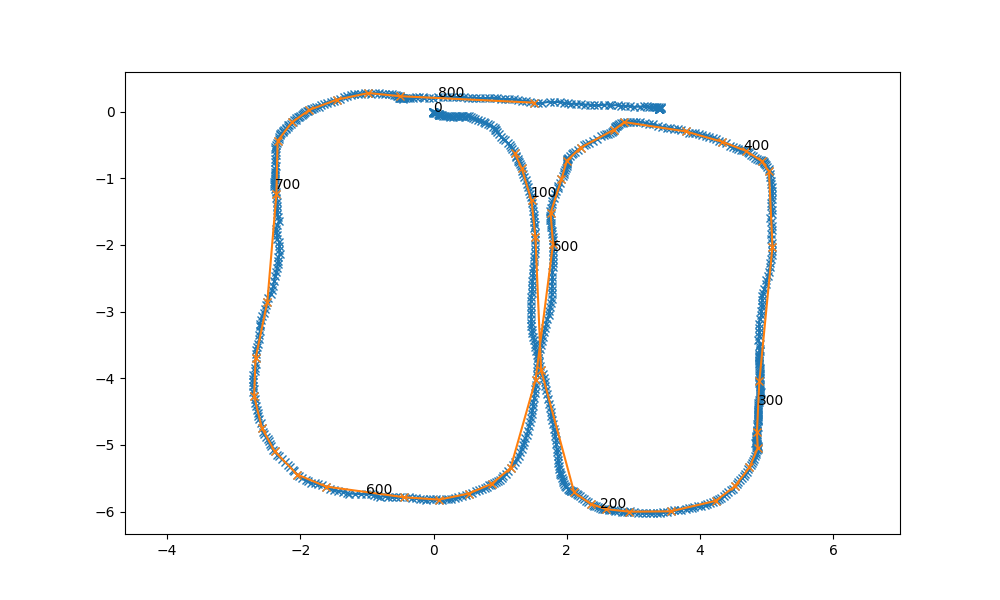

In [8]:
%matplotlib widget
plt.figure(figsize=(10,6))
plt.axis('equal')
plt.plot(poses[:, 0, 3], poses[:,1,3], "-x")
plt.plot(poses_kf[:, 0, 3], poses_kf[:,1,3], "-x")
for i in range(0, poses.shape[0], 100):
    plt.text(poses[i,0,3], poses[i,1,3], str(i))
plt.show()

In [9]:
#df = pd.read_csv("gpsNED.csv")
#df

In [10]:
"""
plt.figure(figsize=(18,10))
plt.scatter(df.iloc[:,0], df.iloc[:,1])
plt.show()
"""

'\nplt.figure(figsize=(18,10))\nplt.scatter(df.iloc[:,0], df.iloc[:,1])\nplt.show()\n'